In [19]:
import pandas as pd
import numpy as np

# Loading dataset

In [20]:
def read_files(path, filenames):
    """Reads all files and returns a dataframe"""
    return pd.concat((pd.read_csv(path + f, skipinitialspace=True) for f in filenames))

In [21]:
path_opt = "./data/raw_data/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for year in range(2016, 2022) for month in range(1, 13)] + ["spx_eod_2022" + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for month in range(1, 13)]
df = read_files(path_opt, filenames_opt)

In [22]:
print(len(df))

5919382


# Cleaning raw data

In [23]:
def process_options(df_opt, call = True):
    """Cleans up column names and add time to maturity (TTM)"""
    keys = {key: key[key.find("[")+1:key.find("]")][0] + key[key.find("[")+1:key.find("]")][1:].lower()  for key in df_opt.keys()}
    df_opt = df_opt.rename(columns=keys)

    if call:
        keys = {"C_ask": "Ask", "C_bid": "Bid"}
    else:
        keys = {"P_ask": "Ask", "P_bid": "Bid"}
    df_opt = df_opt.rename(columns=keys)

    df_opt["Quote_date"] = pd.to_datetime(df_opt["Quote_date"])
    df_opt["Expire_date"] = pd.to_datetime(df_opt["Expire_date"])
    df_opt["TTM"] = df_opt.apply(lambda row: (row.Expire_date - row.Quote_date).days, axis = 1)
    df_opt["Price"] = (df_opt["Ask"] + df_opt["Bid"])/2

    columns = ["Quote_date", "Expire_date", "Price", "Underlying_last", "Strike", "TTM"]
    df_opt = df_opt[columns]
    df_opt = df_opt[(df_opt["TTM"] != 0) & (df_opt["TTM"] <= 365*3)]
    return df_opt[columns]

In [24]:
df = process_options(df)

# Remove NaNs
df_len_before = len(df)
df = df.dropna()
df_len_after = len(df)
print("Dropped " + str(df_len_before - df_len_after) + " rows in by dropping NaNs of processed options")

Dropped 1026 rows in by dropping NaNs of processed options


# Adding lags

In [25]:
df['Quote_date']= pd.to_datetime(df['Quote_date'])
df["Moneyness"] = df.apply(lambda row: row.Underlying_last/row.Strike, axis = 1)

In [26]:
# Group the data by Quote Date and calculate the mean for Underlying Price
df_agg = df.groupby('Quote_date').mean().reset_index()

# Values to returns
df_agg["Underlying_return"] = df_agg["Underlying_last"].pct_change()

lags = 90

# Add the Underlying Price Lag column
for i in range(1, lags + 1):
    df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)

df = pd.merge(df, df_agg[['Quote_date', "Underlying_return"] + ['Underlying_' + str(i) for i in range(1, lags + 1)]], on='Quote_date', how='left')

/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_11036/3936965884.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.groupby('Quote_date').mean().reset_index()
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_11036/3936965884.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_11036/3936965884.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

# Date filtering

In [27]:
start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2022-02-01")
df = df[(df['Quote_date'] >= start_date) & (df['Quote_date'] <= end_date)]

In [28]:
df_len_before = len(df)
df = df.dropna()
df_len_after = len(df)
print("Dropped " + str(df_len_before - df_len_after) + " rows in removing NaNs after lagging")

Dropped 0 rows in removing NaNs after lagging


# Matching rates

In [29]:
def process_rates(df_r):
    """Renames rate duration"""
    df_r["Date"] = pd.to_datetime(df_r["Date"])
    keys = {  "Date" : "Quote_date",
                                    "1 Mo": 30,
                                    "3 Mo": 90,
                                    "6 Mo": 180,
                                    "1 Yr": 365,
                                    "2 Yr": 365*2,
                                    "3 Yr": 365*3,
                                    "5 Yr": 365*5,
                                    "7 Yr": 365*7,
                                    "10 Yr": 365*10}
    df_r = df_r.rename(columns = keys)
    return df_r[keys.values()]

def combine_opt_rates(df_opt, df_r):
    df_opt = pd.merge(df_opt, df_r, on ="Quote_date", how = "left")
    rates = list(df_r.columns)
    rates.remove("Quote_date")
    df_opt["TTM_diff"] = df_opt["TTM"].apply(lambda x: (np.abs(np.array(rates) - x)).argmin())
    df_opt["R"] = df_opt[["TTM_diff"] + rates].values.tolist()
    df_opt["R"] = df_opt["R"].apply(lambda x: x[int(x[0]+1)])
    df_opt = df_opt.drop(rates + ["TTM_diff"], axis=1)
    df_opt = df_opt.ffill()
    df_opt_len_before = len(df_opt)
    df_opt = df_opt.dropna()
    df_opt_len_after = len(df_opt)
    print("Dropped " + str(df_opt_len_before - df_opt_len_after) + " rows in rate matching")
    return df_opt.dropna()

In [30]:
df_r = pd.concat((pd.read_csv("./data/raw_data/" + f, skipinitialspace=True) for f in ["daily-treasury-rates.csv", "yield-curve-rates-1990-2021.csv"]))
df_r = process_rates(df_r)
df = combine_opt_rates(df, df_r)

Dropped 0 rows in rate matching


In [31]:
print(len(df))

2234117


## Read to file

In [32]:
df.to_csv("./data/processed_data/2016-2022_150lags.csv")

<AxesSubplot: ylabel='Frequency'>

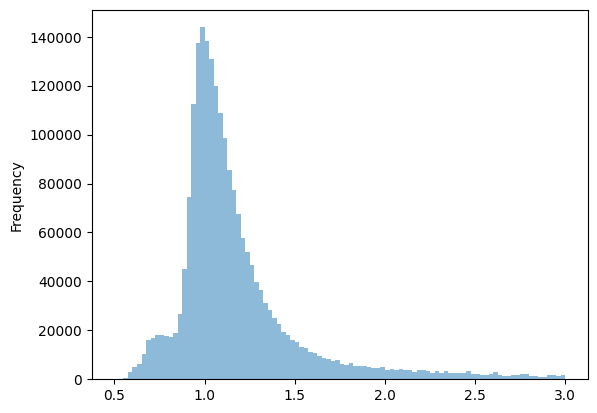

In [35]:
# Plot distribution of Moneyness between 0.5 and 5
df['Moneyness'].plot.hist(bins=100, alpha=0.5, range=(0.5, 3))
# Plot distribution of TTM
#df['TTM'].plot.hist(bins=100, alpha=0.5)